In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F_OLD
import torch as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [5]:
data, label = next(iter(train_loader))

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [7]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [8]:
# load pretrained checkpoints
checkpointEnc = torch.load('Enc_aae_c.pth.tar')
checkpointDec = torch.load('Dec_aae_c.pth.tar')
checkpointDisc = torch.load('Disc_aae_c.pth.tar')

In [9]:
#load pretrained weights
Enc.load_state_dict(checkpointEnc['state_dict'])
Enc_optimizer.load_state_dict(checkpointEnc['optimizer'])

Dec.load_state_dict(checkpointDec['state_dict'])
Dec_optimizer.load_state_dict(checkpointDec['optimizer'])

Disc.load_state_dict(checkpointDisc['state_dict'])
Disc_optimizer.load_state_dict(checkpointDisc['optimizer'])



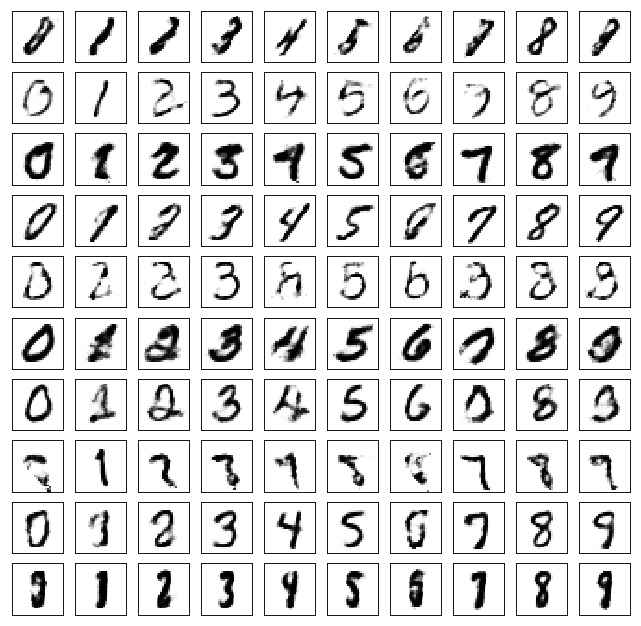

In [10]:
with torch.no_grad():
    fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
    plot_mnist(fixed_gen, (10, 10))

In [11]:
loader = train_loader
with torch.no_grad():
    data, target = next(iter(loader))
    data = Enc(data.to(device))
    print (data.shape)
    print (data)


torch.Size([250, 10])
tensor([[ 1.0434,  1.4715, -1.2044,  ...,  0.9267, -0.0311,  0.6242],
        [-1.0294,  0.3025,  0.0143,  ..., -0.8922,  1.1156,  0.4239],
        [-0.1754,  0.1583, -0.3673,  ..., -0.3592,  0.0835,  0.5086],
        ...,
        [ 0.5823, -0.6928,  0.2093,  ...,  0.6259,  0.5359, -0.7562],
        [-1.6313,  1.6891, -1.3794,  ...,  1.4495, -1.0141, -0.4967],
        [-1.2016,  0.1723, -1.3448,  ...,  1.4483,  0.8892,  1.5714]],
       device='cuda:0')


In [12]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1.1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.to(device)
        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 10)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F_OLD.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F_OLD.nll_loss(output, target, **kwargs)
        return self._loss

In [13]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        with torch.no_grad():
            data = Enc(data)
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target.to(device))
            loss.backward()
            model.optim.step()
            
    if batch_idx % 200 == 0:
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)



In [14]:
models = {'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [15]:
def test(models, loader, log=None, name='Test'):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data = Enc(data)
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target.to(device), reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = f'{name} set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [16]:
for epoch in range(1, 301):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    test(models, train_loader, train_log, name='Train')

Train Epoch: 1 [50000/50000 (100%)]	Losses both: 1.894501
Test set:
both: Loss: 1.9021	Accuracy: 3624/10000 (36%)

Train set:
both: Loss: 1.8929	Accuracy: 18682/50000 (37%)

Train Epoch: 2 [50000/50000 (100%)]	Losses both: 1.754223
Test set:
both: Loss: 1.7774	Accuracy: 3886/10000 (38%)

Train set:
both: Loss: 1.7631	Accuracy: 19985/50000 (39%)

Train Epoch: 3 [50000/50000 (100%)]	Losses both: 1.695257
Test set:
both: Loss: 1.7444	Accuracy: 3963/10000 (39%)

Train set:
both: Loss: 1.7333	Accuracy: 20285/50000 (40%)

Train Epoch: 4 [50000/50000 (100%)]	Losses both: 1.753587
Test set:
both: Loss: 1.7367	Accuracy: 3971/10000 (39%)

Train set:
both: Loss: 1.7197	Accuracy: 20462/50000 (40%)

Train Epoch: 5 [50000/50000 (100%)]	Losses both: 1.770307
Test set:
both: Loss: 1.7325	Accuracy: 3995/10000 (39%)

Train set:
both: Loss: 1.7109	Accuracy: 20705/50000 (41%)

Train Epoch: 6 [50000/50000 (100%)]	Losses both: 1.761475
Test set:
both: Loss: 1.7180	Accuracy: 4037/10000 (40%)

Train set:
both

Train Epoch: 48 [50000/50000 (100%)]	Losses both: 1.210216
Test set:
both: Loss: 1.3710	Accuracy: 5207/10000 (52%)

Train set:
both: Loss: 1.3279	Accuracy: 26928/50000 (53%)

Train Epoch: 49 [50000/50000 (100%)]	Losses both: 1.229479
Test set:
both: Loss: 1.3645	Accuracy: 5232/10000 (52%)

Train set:
both: Loss: 1.3233	Accuracy: 27042/50000 (54%)

Train Epoch: 50 [50000/50000 (100%)]	Losses both: 1.350294
Test set:
both: Loss: 1.3639	Accuracy: 5202/10000 (52%)

Train set:
both: Loss: 1.3218	Accuracy: 27033/50000 (54%)

Train Epoch: 51 [50000/50000 (100%)]	Losses both: 1.292010
Test set:
both: Loss: 1.3673	Accuracy: 5203/10000 (52%)

Train set:
both: Loss: 1.3216	Accuracy: 27012/50000 (54%)

Train Epoch: 52 [50000/50000 (100%)]	Losses both: 1.289118
Test set:
both: Loss: 1.3632	Accuracy: 5215/10000 (52%)

Train set:
both: Loss: 1.3203	Accuracy: 27060/50000 (54%)

Train Epoch: 53 [50000/50000 (100%)]	Losses both: 1.350718
Test set:
both: Loss: 1.3637	Accuracy: 5226/10000 (52%)

Train set

Train Epoch: 95 [50000/50000 (100%)]	Losses both: 1.191831
Test set:
both: Loss: 1.2931	Accuracy: 5490/10000 (54%)

Train set:
both: Loss: 1.2405	Accuracy: 28430/50000 (56%)

Train Epoch: 96 [50000/50000 (100%)]	Losses both: 1.252125
Test set:
both: Loss: 1.2924	Accuracy: 5466/10000 (54%)

Train set:
both: Loss: 1.2420	Accuracy: 28354/50000 (56%)

Train Epoch: 97 [50000/50000 (100%)]	Losses both: 1.273358
Test set:
both: Loss: 1.2904	Accuracy: 5483/10000 (54%)

Train set:
both: Loss: 1.2374	Accuracy: 28511/50000 (57%)

Train Epoch: 98 [50000/50000 (100%)]	Losses both: 1.204559
Test set:
both: Loss: 1.2891	Accuracy: 5499/10000 (54%)

Train set:
both: Loss: 1.2385	Accuracy: 28434/50000 (56%)

Train Epoch: 99 [50000/50000 (100%)]	Losses both: 1.211142
Test set:
both: Loss: 1.2802	Accuracy: 5485/10000 (54%)

Train set:
both: Loss: 1.2376	Accuracy: 28492/50000 (56%)

Train Epoch: 100 [50000/50000 (100%)]	Losses both: 1.330927
Test set:
both: Loss: 1.2879	Accuracy: 5490/10000 (54%)

Train se

Train set:
both: Loss: 1.1994	Accuracy: 29040/50000 (58%)

Train Epoch: 142 [50000/50000 (100%)]	Losses both: 1.164394
Test set:
both: Loss: 1.2531	Accuracy: 5664/10000 (56%)

Train set:
both: Loss: 1.1944	Accuracy: 29148/50000 (58%)

Train Epoch: 143 [50000/50000 (100%)]	Losses both: 1.273262
Test set:
both: Loss: 1.2440	Accuracy: 5619/10000 (56%)

Train set:
both: Loss: 1.1969	Accuracy: 29109/50000 (58%)

Train Epoch: 144 [50000/50000 (100%)]	Losses both: 1.174953
Test set:
both: Loss: 1.2516	Accuracy: 5593/10000 (55%)

Train set:
both: Loss: 1.1942	Accuracy: 29118/50000 (58%)

Train Epoch: 145 [50000/50000 (100%)]	Losses both: 1.204717
Test set:
both: Loss: 1.2565	Accuracy: 5603/10000 (56%)

Train set:
both: Loss: 1.1965	Accuracy: 29141/50000 (58%)

Train Epoch: 146 [50000/50000 (100%)]	Losses both: 1.132858
Test set:
both: Loss: 1.2501	Accuracy: 5605/10000 (56%)

Train set:
both: Loss: 1.1937	Accuracy: 29188/50000 (58%)

Train Epoch: 147 [50000/50000 (100%)]	Losses both: 1.143931
T

Test set:
both: Loss: 1.2431	Accuracy: 5653/10000 (56%)

Train set:
both: Loss: 1.1711	Accuracy: 29554/50000 (59%)

Train Epoch: 189 [50000/50000 (100%)]	Losses both: 1.256243
Test set:
both: Loss: 1.2318	Accuracy: 5672/10000 (56%)

Train set:
both: Loss: 1.1667	Accuracy: 29619/50000 (59%)

Train Epoch: 190 [50000/50000 (100%)]	Losses both: 1.242201
Test set:
both: Loss: 1.2364	Accuracy: 5675/10000 (56%)

Train set:
both: Loss: 1.1695	Accuracy: 29511/50000 (59%)

Train Epoch: 191 [50000/50000 (100%)]	Losses both: 1.082761
Test set:
both: Loss: 1.2326	Accuracy: 5689/10000 (56%)

Train set:
both: Loss: 1.1675	Accuracy: 29615/50000 (59%)

Train Epoch: 192 [50000/50000 (100%)]	Losses both: 1.119079
Test set:
both: Loss: 1.2326	Accuracy: 5683/10000 (56%)

Train set:
both: Loss: 1.1643	Accuracy: 29634/50000 (59%)

Train Epoch: 193 [50000/50000 (100%)]	Losses both: 1.231297
Test set:
both: Loss: 1.2262	Accuracy: 5745/10000 (57%)

Train set:
both: Loss: 1.1707	Accuracy: 29530/50000 (59%)

Trai

Train Epoch: 235 [50000/50000 (100%)]	Losses both: 1.112917
Test set:
both: Loss: 1.2218	Accuracy: 5725/10000 (57%)

Train set:
both: Loss: 1.1437	Accuracy: 30013/50000 (60%)

Train Epoch: 236 [50000/50000 (100%)]	Losses both: 1.058959
Test set:
both: Loss: 1.2217	Accuracy: 5698/10000 (56%)

Train set:
both: Loss: 1.1486	Accuracy: 29892/50000 (59%)

Train Epoch: 237 [50000/50000 (100%)]	Losses both: 1.177891
Test set:
both: Loss: 1.2166	Accuracy: 5729/10000 (57%)

Train set:
both: Loss: 1.1462	Accuracy: 30030/50000 (60%)

Train Epoch: 238 [50000/50000 (100%)]	Losses both: 1.067110
Test set:
both: Loss: 1.2202	Accuracy: 5689/10000 (56%)

Train set:
both: Loss: 1.1473	Accuracy: 29923/50000 (59%)

Train Epoch: 239 [50000/50000 (100%)]	Losses both: 1.287532
Test set:
both: Loss: 1.2253	Accuracy: 5692/10000 (56%)

Train set:
both: Loss: 1.1466	Accuracy: 30051/50000 (60%)

Train Epoch: 240 [50000/50000 (100%)]	Losses both: 1.184299
Test set:
both: Loss: 1.2203	Accuracy: 5753/10000 (57%)

Tra

Train set:
both: Loss: 1.1365	Accuracy: 30057/50000 (60%)

Train Epoch: 282 [50000/50000 (100%)]	Losses both: 1.119882
Test set:
both: Loss: 1.2144	Accuracy: 5711/10000 (57%)

Train set:
both: Loss: 1.1350	Accuracy: 30173/50000 (60%)

Train Epoch: 283 [50000/50000 (100%)]	Losses both: 1.174191
Test set:
both: Loss: 1.2094	Accuracy: 5769/10000 (57%)

Train set:
both: Loss: 1.1388	Accuracy: 30021/50000 (60%)

Train Epoch: 284 [50000/50000 (100%)]	Losses both: 1.129323
Test set:
both: Loss: 1.2076	Accuracy: 5757/10000 (57%)

Train set:
both: Loss: 1.1366	Accuracy: 30176/50000 (60%)

Train Epoch: 285 [50000/50000 (100%)]	Losses both: 1.168075
Test set:
both: Loss: 1.2058	Accuracy: 5782/10000 (57%)

Train set:
both: Loss: 1.1352	Accuracy: 30158/50000 (60%)

Train Epoch: 286 [50000/50000 (100%)]	Losses both: 1.140691
Test set:
both: Loss: 1.2138	Accuracy: 5773/10000 (57%)

Train set:
both: Loss: 1.1355	Accuracy: 30196/50000 (60%)

Train Epoch: 287 [50000/50000 (100%)]	Losses both: 1.267901
T

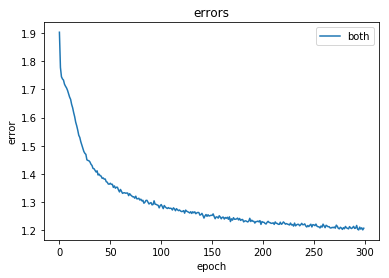

In [22]:
# Проверка "Нечестного" условного автокодировщика
# На выходе енкодера признаки метки сохраняются, поэтому можно извлечь эту информацию
plot_graphs(test_log, 'loss')

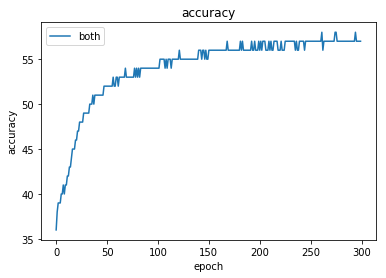

In [23]:
plot_graphs(test_log, 'accuracy')